In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from xgboost import plot_importance
import yaml
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', size=24)
plt.rc('axes', titlepad = 20)
plt.rcParams["figure.figsize"] = [16,10]

# Define paths

In [2]:
data_path = os.path.dirname(os.getcwd()) + '/data/'
figure_path = os.path.dirname(os.getcwd()) + '/figures'
url_template = 'http://www.rcsb.org/pdb/files/{}.pdb'
rest_url='https://www3.cmbi.umcn.nl/xssp/'

# Prepare dataset for the analysis

In [ ]:
df_test = pd.read_csv(data_path + '/benchmarking/test_data.csv')
df_test = df_test[['id','dssp_sequence']]

In [ ]:
# with open(data_path + 'benchmarking/benchmark.txt', 'w') as f: # or .fasta
#     for index, row in df_test.iterrows():
#         pdb_id = row['id']
#         sequence = row['dssp_sequence']
#         f.write(f'>{pdb_id}\n{sequence}\n')

In [ ]:
predictions = pd.read_csv(data_path + '/benchmarking/patchprot_predictions.csv')
predictions = predictions.drop_duplicates(subset=['ID'], keep='first')
predictions['id'] = predictions['ID']
predictions = predictions[predictions['ID'] != '154L']

In [ ]:
prediction_ids = list(predictions['ID'])
failed = df_test[~df_test['id'].isin(prediction_ids)]

In [ ]:
lhp = predictions[['id','LHP_predicted']]
lhp['prediction'] = lhp['LHP_predicted']
lhp.to_csv(data_path + 'benchmarking/lhp_patchprot_prediction.csv')

# Define plotting functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def create_scatter(x, y, xlab, ylab, title):
    plt.scatter(x,y)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    max_point = min(max(list(x)),max(list(y)))
    plt.plot([0,max_point],[0,max_point],'--') # identity line
    plt.show()

def create_heatmap(x, y, xlab, ylab, title):
    plt.hist2d(x,y, bins=100)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.ylim(0,10000)
    plt.xlim(0,10000)
    plt.title(title)
    max_point = min(max(list(x)),max(list(y)))
    plt.plot([0,10000],[0,10000],'--') # identity line
    plt.show()

def perc_corr(y_test, pred, x):
    error = abs(y_test-pred)
    y = [sum(error/y_test < i)/len(error) for i in x]
    return(y)

def perc_perc_corr(y_test, pred, x):
    error = abs(y_test-pred)
    y = [sum(error < i)/len(error) for i in x]
    return(y)

def plot_curve(y_test, pred_dict, step, xlab, ylab, title):
    x = [x/step for x in range(step+1)]
    corr_dict = {pred:perc_corr(y_test, pred_dict[pred], x) for pred in pred_dict}

    plt.figure(figsize=(12,8))

    for corr in corr_dict:
        plt.plot([i*100 for i in x],[i*100 for i in corr_dict[corr]], label=corr)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(figure_path + '/' + title + '.png', dpi = 600, bbox_inches='tight')
    plt.show()

def plot_perc_curve(y_test, pred_dict, step, xlab, ylab, title):
    x = [x/step for x in range(step+1)]
    corr_dict = {pred:perc_perc_corr(y_test, pred_dict[pred], x) for pred in pred_dict}

    plt.figure(figsize=(8,8))

    for corr in corr_dict:
        plt.plot([i*100 for i in x],[i*100 for i in corr_dict[corr]], label=corr)

    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Load the test data

In [4]:
df_test = pd.read_csv(data_path + '/benchmarking/test_data.csv')
df_test

,id,tasa,thsa,dssp_sequence,rhsa,tmp,undefined_count,length,perc_undefined_count,entropy,...,tasa_netsurfp2,q3_H,q3_E,q3_C,rhsa_netsurfp2,on_surface,patch_size,rank,residues,size
0,3G0MA,7872,1647,MAALPDKEKLLRNFTRCANWEEKYLYIIELGQRLAELNPQDRNPQN...,0.209223,False,0.0,138.0,0.0,4.141307,...,8046.278734,75.996086,17.166145,44.837769,0.278213,129.0,36.0,1.0,AWAIAMLLICLMFAIALLLIYFALAFMIFAILLVYY,1119.0
1,1K6KA,8473,1990,MLNQELELSLNMAFARAREHRHEFMTVEHLLLALLSNPSAREALEA...,0.234864,False,0.0,142.0,0.0,3.842851,...,8502.724713,90.878526,5.093134,46.028339,0.235172,125.0,16.0,1.0,LFLLMAFAMLAVLVFV,765.0
2,3NFTA,13480,2727,AMTDDDLRAAGVDRRVPEQKLGAAIDEFASLRLPDRIDGRFVDGRR...,0.202300,False,0.0,262.0,0.0,4.009462,...,15072.980670,168.193999,21.286713,72.519289,0.208330,243.0,16.0,1.0,IILLLIILLVLLVVAF,572.0
3,6QU7A,15720,3376,ATGDERFYAEHLMPTLQGLLDPESAHRLAVRFTSLGLLPRAFQDSD...,0.214758,False,0.0,363.0,0.0,3.961523,...,16852.416883,159.531537,58.082397,145.386066,0.200692,303.0,21.0,1.0,LLLALYALLMVLFYLFFMLFA,1162.0
4,1A5TA,15998,4143,MRWYPWLRPDFEKLVASYQAGRGHHALLIQALPGMGDDALIYALSR...,0.258970,False,0.0,323.0,0.0,4.008869,...,16049.712850,187.619046,30.157108,105.223846,0.272171,282.0,19.0,1.0,WYYYAMAVLWMFYAAALYL,696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,2IIHA,8302,2367,RPRMVDVTEKPETFRTATAEAFVELTEEALSALEKGGVGKGDPLVV...,0.285112,False,0.0,146.0,0.0,3.781968,...,9054.748835,50.566930,47.822518,47.610552,0.289850,127.0,44.0,1.0,ALALALVLLAALAAVICVVLLAIVWYVVVMMVLLLMMVVLLLAI,1926.0
992,3JU4A,36407,10757,VPRGSAKGDGVTDDTAALTSALNDTPVGQKINGNGKTYKVTSLPDI...,0.295465,False,0.0,670.0,0.0,4.163715,...,34528.746352,43.413186,283.261196,343.325615,0.270134,584.0,46.0,1.0,VVAYLVVIYVLYMFFLVYIVLLAMAFAIVAAIAIICFIFLFALFYF,4488.0
993,3II2A,8673,2276,SVVEYEVVSKNLTSKMSHELLFSVKKRWFVKPFRHDRQLGKLHYKL...,0.262424,False,0.0,150.0,0.0,4.100558,...,9516.867448,41.346064,62.291601,46.362336,0.298179,134.0,23.0,1.0,AMYVVVALYIMFAVVYWWLYCYV,832.0
994,5ZBYA,8431,2419,SVLEDVFSGKTRIVICGIGNDVRGDDAFGVLVAERLKELVKTPDVL...,0.286917,False,0.0,156.0,0.0,3.919794,...,7851.492695,62.570569,28.886154,64.543277,0.266700,140.0,42.0,1.0,AALALLVYLAFLIIIVFILLIMIAVIVYFLLLLCIVFILVIV,1549.0


# Check if any of the proteins were in the training dataset for PatchProt

In [8]:
# import numpy as np
# import pandas as pd

# def extract_and_save_list_dataset(input_path, output_csv_path):
#     # Load the extended dataset
#     extended_data = np.load(input_path)
    
#     # Extract data and pdbids
#     data = extended_data['data']
#     pdbids = extended_data['pdbids']
    
#     # Assuming the columns 69, 70, and 71 correspond to THSA, RHSA, and LHP
#     thsa_list = [data[i, 0, 69] for i in range(data.shape[0])]
#     rhsa_list = [data[i, 0, 70] for i in range(data.shape[0])]
#     lhp_list = [data[i, 0, 71] for i in range(data.shape[0])]
    
#     # Create a DataFrame with PDB IDs and lists
#     df = pd.DataFrame({'PDB_ID': pdbids, 'THSA': thsa_list, 'RHSA': rhsa_list, 'LHP': lhp_list})
    
#     # Save DataFrame as a CSV file
#     df.to_csv(output_csv_path, index=False)

In [9]:
# extract_and_save_list_dataset(data_path + '../../data/extended/Jan/Train_HHblits_extended.npz', 
#                               data_path + 'patches/Train_LHP.csv')
# extract_and_save_list_dataset(data_path + '../../data/extended/Jan/CASP12_HHblits_extended.npz', 
#                               data_path + 'patches/CASP12_LHP.csv')
# extract_and_save_list_dataset(data_path + '../../data/extended/Jan/CB513_HHblits_extended.npz', 
#                               data_path + 'patches/CB513_LHP.csv')
# extract_and_save_list_dataset(data_path + '../../data/extended/Jan/TS115_HHblits_extended.npz', 
#                               data_path + 'patches/TS115_LHP.csv')

In [13]:
train_data = pd.read_csv(data_path + '/patches/Train_LHP.csv')
train_data = train_data[train_data['LHP'] > 0]

In [14]:
def convert_string(input_str):
    # Remove the "-" character and capitalize the letters
    converted_str = input_str.replace("-", "").upper()
    return converted_str

train_data['id'] = [convert_string(row) for row in train_data['PDB_ID']]

merged_data = pd.merge(df_test, train_data, on='id', how='inner')
len(merged_data)

650

# Select ids that we have predictions for from PatchProt

In [24]:
predictions = pd.read_csv(data_path + '/benchmarking/patchprot_predictions.csv')
predictions = predictions.drop_duplicates(subset=['ID'], keep='first')
#predictions.to_csv(data_path + '/benchmarking/patchprot_predictions.csv')
predictions = predictions[predictions['ID'] != '154L'] #case example that is not in the benchmark dataset
predictions

,ID,Fasta_sequence,SS3_predicted,SS8_predicted,TASA_predicted,THSA_predicted,RHSA_predicted,LHP_predicted,Species,Expression
1,3G0MA,MAALPDKEKLLRNFTRCANWEEKYLYIIELGQRLAELNPQDRNPQN...,CCCCCCHHHHHHHHHCCCCHHHHHHHHHHHHHHCCCCCHHHCCHHC...,CCCCCCHHHHHHHHHTCSCHHHHHHHHHHHHHTCCCCCGGGCCGGG...,7115.4043,1853.0613,0.260429,750.68225,HOMO SAPIENS,0%
2,1K6KA,MLNQELELSLNMAFARAREHRHEFMTVEHLLLALLSNPSAREALEA...,CCCHHHHHHHHHHHHHHHHCCCCCCCHHHHHHHHHCCHHHHHHHHH...,CCCHHHHHHHHHHHHHHHHTTCSSCCHHHHHHHHHTCHHHHHHHHH...,7230.2397,1870.9785,0.258771,691.38870,ESCHERICHIA COLI,0%
3,3NFTA,AMTDDDLRAAGVDRRVPEQKLGAAIDEFASLRLPDRIDGRFVDGRR...,CCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCCCCCCCCCCCCCCC...,CCCCCCCCCCCCCCCCCCCCHHHHHHHHHCCCCCCCCCCCCCCCCC...,11927.8400,2598.1016,0.217818,792.47534,HOMO SAPIENS,0%
4,6QU7A,ATGDERFYAEHLMPTLQGLLDPESAHRLAVRFTSLGLLPRAFQDSD...,CCCCCCCCHCCCHHHHHCCCCHHHHHHHHHHHHHCCCCCCCCCCCC...,CCCCCCCCHCCCCHHHHCCCCHHHHHHHHHHHHHTCCCCCCCCCCT...,14867.2060,3458.9550,0.232657,1251.96230,MYCOBACTERIUM TUBERCULOSIS,0%
5,1A5TA,MRWYPWLRPDFEKLVASYQAGRGHHALLIQALPGMGDDALIYALSR...,CCCCHHHHHHHHHHHHHHHCCCCCCEEEEECCCCCCHHHHHHHHHH...,CCCCGGHHHHHHHHHHHHHTTCCCCEEEEECCTTTCHHHHHHHHHH...,15649.0380,4178.4920,0.267013,1100.87390,ESCHERICHIA COLI,0%
...,...,...,...,...,...,...,...,...,...,...
992,2IIHA,RPRMVDVTEKPETFRTATAEAFVELTEEALSALEKGGVGKGDPLVV...,CCCCCCCCCCCCCEEEEEEEEEEECCHHHHHHHHCCCCCCCCHHHH...,CCCCCCCTCCCCCEEEEEEEEEEECCHHHHHHHHTTCCCCSCHHHH...,7224.7000,2288.2751,0.316729,1354.66060,HOMO SAPIENS,0%
993,3JU4A,VPRGSAKGDGVTDDTAALTSALNDTPVGQKINGNGKTYKVTSLPDI...,CCCCCCCCCCCCCCHHHHHHHHHCCCCCCEEECCCCEEECCCCCCC...,CCCTTCCCCTSCCCHHHHHHHHHHCCTTCEEECTTCEEECSSCCCC...,31922.6780,10027.2260,0.314110,3394.57760,HOMO SAPIENS,0%
994,3II2A,SVVEYEVVSKNLTSKMSHELLFSVKKRWFVKPFRHDRQLGKLHYKL...,CCCEEEEEECCCCCCCCHHHEEEEECCEEECCCCCCCCCCEEEEEE...,CCCEEEEEEECCCCCCCEEEEEEEEEEEEEECEEECEEEEEEEEEE...,7955.0156,2225.5286,0.279764,672.20840,HOMO SAPIENS,0%
995,5ZBYA,SVLEDVFSGKTRIVICGIGNDVRGDDAFGVLVAERLKELVKTPDVL...,CCHHHHCCCCCEEEEEEECCCCCCHHHHHHHHHHHHHHHCCCCCEE...,CCCHHHCTTCCEEEEEEECCTTTTTHHHHHHHHHHHHHHCCCTTEE...,7243.7363,2046.6733,0.282544,1124.88350,HOMO SAPIENS,0%


In [25]:
ids_to_keep = list(predictions['ID'])
len(ids_to_keep)

996

In [26]:
all_ids = list(df_test['id'])
len(all_ids)

996

In [27]:
df_test = df_test[df_test['id'].isin(ids_to_keep)]

In [29]:
overlapping = list(train_data['id'])
filtered_test = df_test[~df_test['id'].isin(overlapping)]
filtered_ids = list(filtered_test['id'])
len(filtered_ids)

346

# Calculate performance

# Including all proteins

R2 score  NetSurfP2 trained model 0.430891519315191
R2 score  GFM 0.12184275218819451
R2 score  TFM -0.003208559248944809
R2 score  PatchProt 0.471910915526052


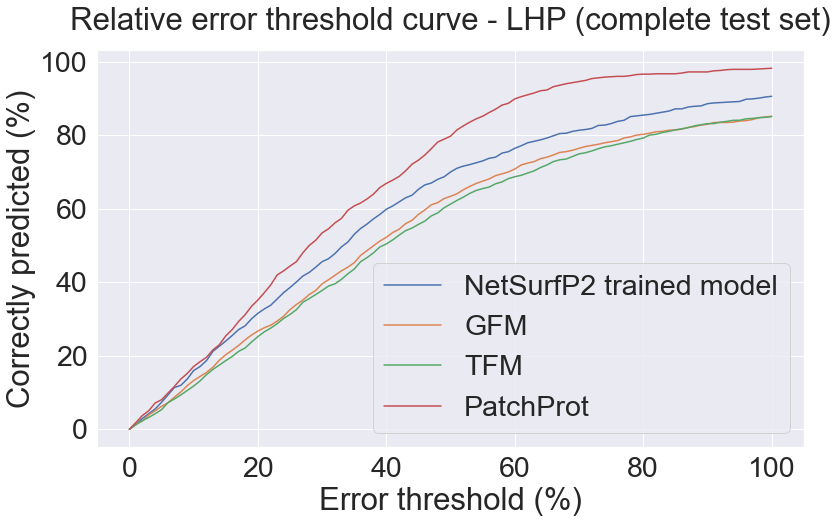

In [32]:
names =  {'nsp2':'NetSurfP2 trained model', 'gfm':'GFM', 'tfm':'TFM', 'patchprot':'PatchProt'}
pred_dict = {}
for name in names:
    if name == 'tfm':
        result = pd.read_csv(data_path + 'benchmarking/lhp_tfm_prediction.csv')
        result['id'] = all_ids
        result = result[result['id'].isin(ids_to_keep)]
        result = result['x']
    else:
        result = pd.read_csv(data_path + 'benchmarking/lhp_'+name+'_prediction.csv')
        result = result[result['id'].isin(ids_to_keep)]
        result = result['prediction']
    
    pred_dict[names[name]] = result
    
for name in pred_dict:
    print('R2 score ',name, r2_score(df_test['size'], pred_dict[name]))

xlab = 'Error threshold (%)'
ylab = 'Correctly predicted (%)'
title = 'Relative error threshold curve - LHP (complete test set)'
plot_curve(df_test['size'], pred_dict, 100, xlab, ylab, title)

# Only non overlapping proteins

R2 score  NBM 0.3868316293773765
R2 score  GFM 0.09624440802302958
R2 score  TFM -0.0066695879693450255
R2 score  PatchProt 0.38669973868190455


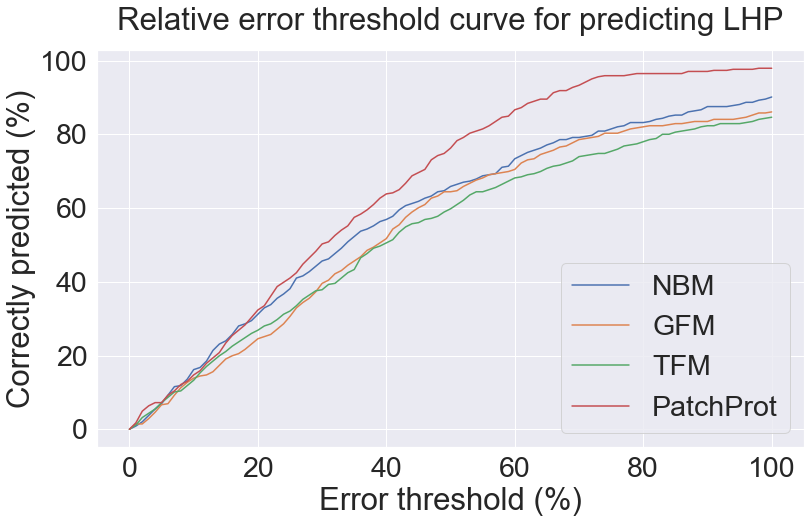

In [34]:
names =  {'nsp2':'NBM', 'gfm':'GFM', 'tfm':'TFM', 'patchprot':'PatchProt'}
pred_dict = {}
for name in names:
    if name == 'tfm':
        result = pd.read_csv(data_path + 'benchmarking/lhp_tfm_prediction.csv')
        result['id'] = all_ids
        result = result[result['id'].isin(filtered_ids)]
        result = result['x']
    else:
        result = pd.read_csv(data_path + 'benchmarking/lhp_'+name+'_prediction.csv')
        result = result[result['id'].isin(filtered_ids)]
        result = result['prediction']
    
    pred_dict[names[name]] = result
    
for name in pred_dict:
    print('R2 score ',name, r2_score(filtered_test['size'], pred_dict[name]))

xlab = 'Error threshold (%)'
ylab = 'Correctly predicted (%)'
title = 'Relative error threshold curve for predicting LHP'
plot_curve(filtered_test['size'], pred_dict, 100, xlab, ylab, title)